In [1]:
import numpy as np
import torch
from tqdm import tqdm
from Gridworld import * 
import matplotlib.pyplot as plt

In [135]:
model = torch.nn.Sequential(
    torch.nn.Linear(64,150),
    torch.nn.ReLU(),
    torch.nn.Linear(150,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4),
    torch.nn.Softmax(dim=-1)   # VERY IMPRESSIVE IMPROVEMENT!
)

loss_f = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [136]:
from collections import deque
from random import sample
epsilon = 1.
discount = 0.9
epochs = 5000
losses = []
batch_size = 40
mem_size = 80
replay = deque(maxlen = mem_size)
max_moves = 60
for _ in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='random')
    state = game.board.render_np().flatten().astype('float')
    state += np.random.rand(64) / 100. 
    state = torch.Tensor(state)
    gameover = 0
    moves = 0
    while not gameover:
        moves += 1
        qval = model(state)
        qval_ = qval.detach().numpy()
        if np.random.random() < epsilon:
            action = np.random.randint(0,4)
        else:
            action = np.argmax(qval_)

        game.makeMove('udlr'[action])
        state2 = game.board.render_np().flatten().astype('float')
        state2 += np.random.rand(64) / 100. 
        state2 = torch.Tensor(state2)
        reward = game.reward()
        #if reward != 0:
        #    gameover = 1

        replay.append((state, action, reward-0.01, state2, gameover))
        state = state2

        if len(replay) > batch_size:
            minibatch = sample(replay, batch_size)
            state_batch = torch.cat([s for (s,a,r,s2,g) in minibatch]).reshape((batch_size, 64))
            action_batch = torch.Tensor([a for (s,a,r,s2,g) in minibatch])
            reward_batch = torch.Tensor([r for (s,a,r,s2,g) in minibatch])
            state2_batch = torch.cat([s2 for (s,a,r,s2,g) in minibatch]).reshape((batch_size, 64))
            gameover_batch = torch.Tensor([g for (s,a,r,s2,g) in minibatch])

            predict = model(state_batch)
            predict = predict.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()

            with torch.no_grad():
                reference = model(state2_batch)
            reference = reward_batch + discount * (1 - gameover_batch) * torch.max(reference, dim=1)[0]

            loss = loss_f(reference, predict)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if reward != 0 or moves > max_moves:
            gameover = True
    
    if epsilon > 0.1:
        epsilon -= (1. /epochs)

100%|██████████| 5000/5000 [02:02<00:00, 40.90it/s]


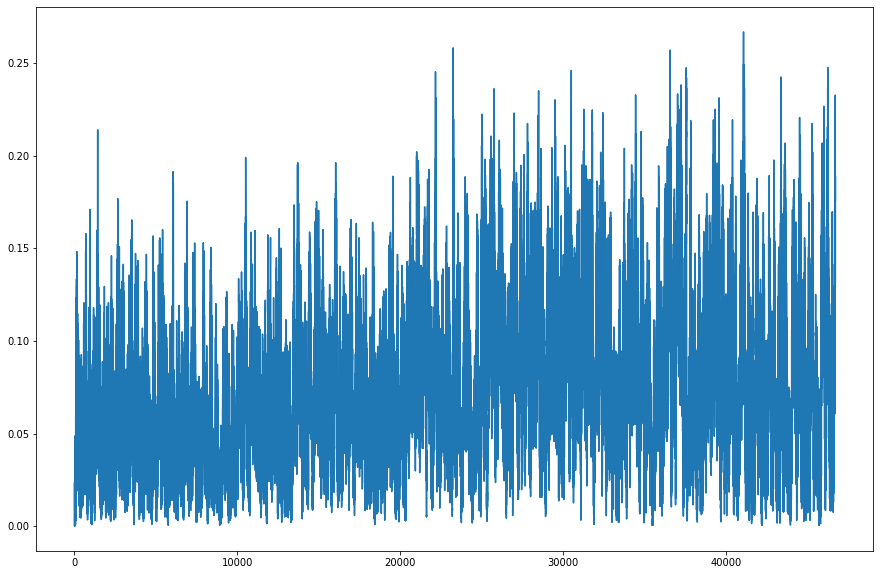

In [137]:
plt.figure(figsize=(15,10))
plt.plot(losses)

In [5]:
def testModel(model, mode='random', display=True):
    game = Gridworld(size=4, mode=mode)
    if display:
        print(game.display())
    gameover = 0
    moves = 0
    while not gameover and moves < 40:
        moves += 1
        state = game.board.render_np().flatten().astype('float')
        state = torch.Tensor(state)
        qval = model(state).detach().numpy()
        action = np.argmax(qval)
        game.makeMove('udlr'[action])
        if display:
            print('udlr'[action],end = ' ')
        if game.reward() != 0:
            gameover = 1
    return game.reward() == 1    

In [206]:
testModel(model)

[[' ' '-' ' ' ' ']
 [' ' ' ' 'P' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']]
r 

True

In [140]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model, 'random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 818
Win percentage: 0.818
